_Developer Note:_ if you may make a PR in the future, be sure to copy this
notebook, and use the `gitignore` prefix `temp` to avoid future conflicts.

This is one notebook in a multi-part series on clusterless decoding in Spyglass

- To set up your Spyglass environment and database, see
  [the Setup notebook](./00_Setup.ipynb)
- For additional info on DataJoint syntax, including table definitions and
  inserts, see
  [the Insert Data notebook](./01_Insert_Data.ipynb)
- Prior to running, please familiarize yourself with the [spike sorting
  pipeline](./02_Spike_Sorting.ipynb) and generate input position data with
  either the [Trodes](./20_Position_Trodes.ipynb) or DLC notebooks
  ([1](./21_Position_DLC_1.ipynb), [2](./22_Position_DLC_2.ipynb),
  [3](./23_Position_DLC_3.ipynb)).

The goal of this notebook is to populate the `UnitWaveformFeatures` table, which depends `SpikeSortingOutput`. This table contains the features of the waveforms of each unit.

While clusterless decoding avoids actual spike sorting, we need to pass through these tables to maintain (relative) pipeline simplicity. Pass-through tables keep spike sorting and clusterless waveform extraction as similar as possible, by using shared steps. Here, "spike sorting" involves simple thresholding (sorter: clusterless_thresholder).


In [1]:
from pathlib import Path
import datajoint as dj

dj.config.load(
    Path("../dj_local_conf.json").absolute()
)  # load config for database connection info

First, if you haven't inserted the the `mediumnwb20230802.wnb` file into the database, you should do so now. This is the file that we will use for the decoding tutorials.

It is a truncated version of the full NWB file, so it will run faster, but bigger than the minirec file we used in the previous tutorials so that decoding makes sense.


In [2]:
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
import spyglass.data_import as sgi
import spyglass.position as sgp

# Insert the nwb file
nwb_file_name = "mediumnwb20230802.nwb"
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
sgi.insert_sessions(nwb_file_name)

# Position
sgp.v1.TrodesPosParams.insert_default()

interval_list_name = "pos 0 valid times"

trodes_s_key = {
    "nwb_file_name": nwb_copy_file_name,
    "interval_list_name": interval_list_name,
    "trodes_pos_params_name": "default",
}
sgp.v1.TrodesPosSelection.insert1(
    trodes_s_key,
    skip_duplicates=True,
)
sgp.v1.TrodesPosV1.populate(trodes_s_key)

[2024-04-19 10:37:45,302][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2024-04-19 10:37:45,330][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306
/home/sambray/Documents/spyglass/src/spyglass/data_import/insert_sessions.py:58: UserWarning: Cannot insert data from mediumnwb20230802.nwb: mediumnwb20230802_.nwb is already in Nwbfile table.
  warnings.warn(


These next steps are the same as in the [Spike Sorting notebook](./10_Spike_SortingV1.ipynb), but we'll repeat them here for clarity. These are pre-processing steps that are shared between spike sorting and clusterless decoding.

We first set the `SortGroup` to define which contacts are sorted together.

We then setup for spike sorting by bandpass filtering and whitening the data via the `SpikeSortingRecording` table.


In [3]:
import spyglass.spikesorting.v1 as sgs

sgs.SortGroup.set_group_by_shank(nwb_file_name=nwb_copy_file_name)

sort_group_ids = (sgs.SortGroup & {"nwb_file_name": nwb_copy_file_name}).fetch(
    "sort_group_id"
)

group_keys = []
for sort_group_id in sort_group_ids:
    key = {
        "nwb_file_name": nwb_copy_file_name,
        "sort_group_id": sort_group_id,
        "interval_list_name": interval_list_name,
        "preproc_param_name": "default",
        "team_name": "Alison Comrie",
    }
    group_keys.append(key)
    sgs.SpikeSortingRecordingSelection.insert_selection(key)

sgs.SpikeSortingRecording.populate(group_keys)

[10:37:53][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:53][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:53][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:53][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:53][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:53][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:53][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:53][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:53][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:53][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:53][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:53][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:53][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:53][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:53][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:53][WARNING] Spyglass: Similar row(s) already in

Next we do artifact detection. Here we skip it by setting the `artifact_param_name` to `None`, but in practice you should detect artifacts as it will affect the decoding.


In [4]:
recording_ids = (
    sgs.SpikeSortingRecordingSelection & {"nwb_file_name": nwb_copy_file_name}
).fetch("recording_id")

group_keys = []
for recording_id in recording_ids:
    key = {
        "recording_id": recording_id,
        "artifact_param_name": "none",
    }
    group_keys.append(key)
    sgs.ArtifactDetectionSelection.insert_selection(key)

sgs.ArtifactDetection.populate(group_keys)

[10:37:56][WARNING] Spyglass: Similar row(s) already inserted.


[10:37:56][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:56][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:56][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:56][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:56][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:56][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:56][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:56][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:56][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:56][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:56][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:56][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:56][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:56][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:56][WARNING] Spyglass: Similar row(s) already inserted.
[10:37:56][WARNING] Spyglass: Similar row(s) already in

Now we run the "spike sorting", which in our case is simply thresholding the signal to find spikes. We use the `SpikeSorting` table to store the results. Note that `sorter_param_name` defines the parameters for thresholding the signal.


In [5]:
(sgs.SpikeSorterParameters() & {"sorter": "clusterless_thresholder"}).fetch1()

{'sorter': 'clusterless_thresholder',
 'sorter_param_name': 'default_clusterless',
 'sorter_params': {'detect_threshold': 100.0,
  'method': 'locally_exclusive',
  'peak_sign': 'neg',
  'exclude_sweep_ms': 0.1,
  'local_radius_um': 100,
  'noise_levels': array([1.]),
  'random_chunk_kwargs': {},
  'outputs': 'sorting'}}

In [23]:
group_keys = []
for recording_id in recording_ids:
    key = {
        "recording_id": recording_id,
        "sorter": "clusterless_thresholder",
        "sorter_param_name": "default_clusterless",
        "nwb_file_name": nwb_copy_file_name,
        "interval_list_name": str(
            (
                sgs.ArtifactDetectionSelection
                & {"recording_id": recording_id, "artifact_param_name": "none"}
            ).fetch1("artifact_id")
        ),
    }
    group_keys.append(key)
    sgs.SpikeSortingSelection.insert_selection(key)
sort_keys = (sgs.SpikeSortingSelection & group_keys).fetch("KEY")
sgs.SpikeSorting.populate(sort_keys)

[12:03:38][INFO] Spyglass: Similar row(s) already inserted.
[12:03:38][INFO] Spyglass: Similar row(s) already inserted.


[12:03:38][INFO] Spyglass: Similar row(s) already inserted.
[12:03:38][INFO] Spyglass: Similar row(s) already inserted.
[12:03:38][INFO] Spyglass: Similar row(s) already inserted.
[12:03:38][INFO] Spyglass: Similar row(s) already inserted.
[12:03:38][INFO] Spyglass: Similar row(s) already inserted.
[12:03:38][INFO] Spyglass: Similar row(s) already inserted.
[12:03:38][INFO] Spyglass: Similar row(s) already inserted.
[12:03:38][INFO] Spyglass: Similar row(s) already inserted.
[12:03:39][INFO] Spyglass: Similar row(s) already inserted.
[12:03:39][INFO] Spyglass: Similar row(s) already inserted.
[12:03:39][INFO] Spyglass: Similar row(s) already inserted.
[12:03:39][INFO] Spyglass: Similar row(s) already inserted.
[12:03:39][INFO] Spyglass: Similar row(s) already inserted.
[12:03:39][INFO] Spyglass: Similar row(s) already inserted.
[12:03:39][INFO] Spyglass: Similar row(s) already inserted.
[12:03:39][INFO] Spyglass: Similar row(s) already inserted.
[12:03:39][INFO] Spyglass: Similar row(s

For clusterless decoding we do not need any manual curation, but for the sake of the pipeline, we need to store the output of the thresholding in the `CurationV1` table and insert this into the `SpikeSortingOutput` table.


In [31]:
sgs.SpikeSorting().populate(
    sgs.SpikeSortingSelection
    & {
        "nwb_file_name": nwb_copy_file_name,
        "sorter": "clusterless_thresholder",
        "sorter_param_name": "default_clusterless",
    }
)

detect peaks using locally_exclusive:   0%|          | 0/1476 [00:00<?, ?it/s]

/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'e-series': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: TimeSeries 'analog': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
[12:10:21][INFO] Spyglass: Writing new NWB file mediumnwb20230802_UB40ETS0L4.nwb
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/build/objectmapper.py:668: MissingRequiredBuildWarning: NWBFile 'root' is missing required value for attribute 'source_script_file_name'.
  warnings.warn(msg, Missin

In [34]:
from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput

sorting_ids = (
    sgs.SpikeSortingSelection
    & {
        "nwb_file_name": nwb_copy_file_name,
        "sorter": "clusterless_thresholder",
        "sorter_param_name": "default_clusterless",
    }
).fetch("sorting_id")

for sorting_id in sorting_ids:
    try:
        sgs.CurationV1.insert_curation(sorting_id=sorting_id)
    except KeyError:
        pass

SpikeSortingOutput.insert(
    sgs.CurationV1().fetch("KEY"),
    part_name="CurationV1",
    skip_duplicates=True,
)

Finally, we extract the waveform features of each SortGroup. This is done by the `UnitWaveformFeatures` table.

To set this up, we use the `WaveformFeaturesParams` to define the time around the spike that we want to use for feature extraction, and which features to extract. Here is an example of the parameters used for extraction the amplitude of the negative peak of the waveform:

```python

waveform_extraction_params = {
    "ms_before": 0.5,
    "ms_after": 0.5,
    "max_spikes_per_unit": None,
    "n_jobs": 5,
    "total_memory": "5G",
}
waveform_feature_params = {
    "amplitude": {
        "peak_sign": "neg",
        "estimate_peak_time": False,
    }
}
```

We see that we want 0.5 ms of time before and after the peak of the negative spike. We also see that we want to extract the amplitude of the negative peak, and that we do not want to estimate the peak time (since we know it is at 0 ms).

You can define other features to extract such as spatial location of the spike:

```python
waveform_extraction_params = {
    "ms_before": 0.5,
    "ms_after": 0.5,
    "max_spikes_per_unit": None,
    "n_jobs": 5,
    "total_memory": "5G",
}
waveform_feature_params = {
    "amplitude": {
        "peak_sign": "neg",
        "estimate_peak_time": False,
    },
    "spike location": {}
}

```

_Note_: Members of the Frank Lab can use "ampl_10_jobs_v2" instead of "amplitude"
for significant speed improvements.


In [1]:
from spyglass.decoding.v1.waveform_features import WaveformFeaturesParams

waveform_extraction_params = {
    "ms_before": 0.5,
    "ms_after": 0.5,
    "max_spikes_per_unit": None,
    "n_jobs": 5,
    "total_memory": "5G",
}
waveform_feature_params = {
    "amplitude": {
        "peak_sign": "neg",
        "estimate_peak_time": False,
    }
}

WaveformFeaturesParams.insert1(
    {
        "features_param_name": "amplitude",
        "params": {
            "waveform_extraction_params": waveform_extraction_params,
            "waveform_feature_params": waveform_feature_params,
        },
    },
    skip_duplicates=True,
)

WaveformFeaturesParams()

/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/non_local_detector/likelihoods/clusterless_kde.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[2024-04-19 12:40:14,102][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2024-04-19 12:40:14,138][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


features_param_name a name for this set of parameters,params the parameters for the waveform features
amplitude,=BLOB=
"amplitude, spike_location",=BLOB=


Now that we've inserted the waveform features parameters, we need to define which parameters to use for each SortGroup. This is done by the `UnitWaveformFeaturesSelection` table. We need to link the primary key `merge_id` from the `SpikeSortingOutput` table to a features parameter set.


In [2]:
from spyglass.decoding.v1.waveform_features import UnitWaveformFeaturesSelection

UnitWaveformFeaturesSelection()

spikesorting_merge_id,features_param_name a name for this set of parameters
003bf29a-fa09-05be-5cac-b7ea70a48c0c,amplitude
004faf9a-72cb-4416-ae13-3f85d538604f,amplitude
0061a9df-3954-99d4-d738-fd13ab7119fe,amplitude
00775472-67a6-5836-b68a-d15186ae3b3c,amplitude
00a1861f-bbf0-5e78-3dc6-36551b2657b0,amplitude
00a9f0d0-b682-2b12-6a2b-08e4129291ce,amplitude
00bd2bbf-ccdb-7be3-f1a0-5e337d87a5a4,amplitude
00bdda4f-7059-6c72-c571-a80ad323fda2,amplitude
00db0baa-4ec0-3d20-897a-ea4a067ebbba,amplitude
00e5a16b-c4f2-e8dc-3083-17f542dadc36,amplitude


First we find the units we need.  We can use the method `SpikeSortingOutput.get_restricted_merge_ids()` to perform the needed joins to find them:


In [6]:
nwb_copy_file_name = "mediumnwb20230802_.nwb"
from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput

In [7]:
key = {
    "nwb_file_name": nwb_copy_file_name,
    "sorter": "clusterless_thresholder",
    "sorter_param_name": "default_clusterless",
}
merge_ids = SpikeSortingOutput().get_restricted_merge_ids(
    {
        "nwb_file_name": nwb_copy_file_name,
        "sorter": "clusterless_thresholder",
        "sorter_param_name": "default_clusterless",
    },
    sources=["v1"],
)

Then we link them with the features parameters:


In [8]:
selection_keys = [
    {
        "spikesorting_merge_id": merge_id,
        "features_param_name": "amplitude",
    }
    for merge_id in merge_ids
]
UnitWaveformFeaturesSelection.insert(selection_keys, skip_duplicates=True)

UnitWaveformFeaturesSelection & selection_keys

spikesorting_merge_id,features_param_name a name for this set of parameters
0233e49a-b849-7eab-7434-9c298eea87b8,amplitude
07239cea-7578-5409-692c-18c9d26b4d36,amplitude
08be9775-370d-6492-0b4e-a5db4ce7a128,amplitude
11819f33-11d5-f0f8-2590-ce3d60b76f3a,amplitude
1c2ea289-2e7f-dcda-0464-ce97d3d6a392,amplitude
20f24092-d191-0c58-55c8-d43d453f9fd4,amplitude
2598b48e-49a0-3389-dd15-0230e8d326e4,amplitude
483055a5-9775-27b7-856e-01543bd920aa,amplitude
50ae3f7e-65a8-5fc2-5304-ab534b90fa46,amplitude
50b29d01-2d74-e37e-2842-ad56d833c5f9,amplitude


Finally, we extract the waveform features, by populating the `UnitWaveformFeatures` table:


In [13]:
from spyglass.decoding.v1.waveform_features import UnitWaveformFeatures

UnitWaveformFeatures.populate(selection_keys)

In [12]:
UnitWaveformFeatures & selection_keys

spikesorting_merge_id,features_param_name a name for this set of parameters,analysis_file_name name of the file,object_id the NWB object that stores the waveforms
0751a1e1-a406-7f87-ae6f-ce4ffc60621c,amplitude,mediumnwb20230802_NQEPSMKPK0.nwb,8607d6a6-213c-431d-ab99-70196b6cf0bf
485a4ddf-332d-35b5-3ad4-0561736c1844,amplitude,mediumnwb20230802_F02UG5Z5FR.nwb,9f693a74-a203-4628-b3ec-50a32b3549d8
4a712103-c223-864f-82e0-6c23de79cc14,amplitude,mediumnwb20230802_OTV91MLKDT.nwb,648953e8-1891-4c90-9756-d6b7cc2b7c3d
4a72c253-b3ca-8c13-e615-736a7ebff35c,amplitude,mediumnwb20230802_TSPNTCGNN1.nwb,6d0af664-f811-4781-9a23-cac437fb2d15
5c53bd33-d57c-fbba-e0fb-55e0bcb85d03,amplitude,mediumnwb20230802_QSK70WFDJH.nwb,a67ed5bb-3edd-465e-8737-ee08f3e7d7d5
614d796c-0b95-6364-aaa0-b6cb1e7bbb83,amplitude,mediumnwb20230802_DO45HKXYTB.nwb,13218b00-bf34-455c-9c38-c3b3174d4009
6acb99b8-6a0c-eb83-1141-5f603c5895e0,amplitude,mediumnwb20230802_KFIYRJ4HFO.nwb,d892bb47-94fc-4c29-acab-d5b3d9565c97
6d039a63-17ad-0b78-4b1e-f02d5f3dbbc5,amplitude,mediumnwb20230802_0YIM5K3H47.nwb,60f4d280-a42a-4a77-9c35-9bd4d2c76991
74e10781-1228-4075-0870-af224024ffdc,amplitude,mediumnwb20230802_CTLEGE2TWZ.nwb,99f51e3d-54b5-41d7-a61e-7013b22fb066
7e3fa66e-727e-1541-819a-b01309bb30ae,amplitude,mediumnwb20230802_7EN0N1U4U1.nwb,535b28d1-c9b5-4d7d-a4f5-4d80508542b4


Now that we've extracted the data, we can inspect the results. Let's fetch the data:


In [13]:
spike_times, spike_waveform_features = (
    UnitWaveformFeatures & selection_keys
).fetch_data()

[2024-01-17 22:19:07,354][WARNING]: Skipped checksum for file with hash: a7c9b1d9-d1a2-7f40-9127-206e83a87006, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_NQEPSMKPK0.nwb
[2024-01-17 22:19:07,359][WARNING]: Skipped checksum for file with hash: ec7faa5b-3847-6649-1a93-74ebd50dcfb9, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_F02UG5Z5FR.nwb
[2024-01-17 22:19:07,369][WARNING]: Skipped checksum for file with hash: 8e964932-96ab-e1c9-2133-edce8eacab5f, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_OTV91MLKDT.nwb
[2024-01-17 22:19:07,379][WARNING]: Skipped checksum for file with hash: 895bac7b-bfd6-b4f2-b2ad-460362aaafa8, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/mediumnwb20230802/mediumnwb20230802_TSPNTCGNN1.nwb
[2024-01-17 22:19:07,382][WARNING]: Skipped checksum for file with hash: 58713583-cf49-4527-7707-105

Let's look at the features shape. This is a list corresponding to tetrodes, with each element being a numpy array of shape (n_spikes, n_features). The features in this case are the amplitude of each tetrode wire at the negative peak of the waveform.


In [14]:
for features in spike_waveform_features:
    print(features.shape)

(49808, 4)
(21675, 4)
(21024, 4)
(51330, 4)
(43804, 4)
(6348, 4)
(12188, 4)
(2654, 4)
(99400, 4)
(8952, 4)
(39886, 4)
(18, 4)
(44284, 4)
(8283, 4)
(36687, 4)
(803, 4)
(76353, 4)
(11367, 4)
(41622, 4)
(106549, 4)
(57394, 4)
(30772, 4)
(4198, 4)


We can plot the amplitudes to see if there is anything that looks neural and to look for outliers:


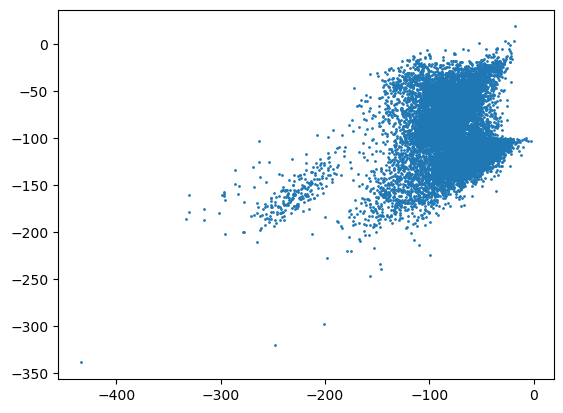

In [15]:
import matplotlib.pyplot as plt

tetrode_ind = 1
plt.scatter(
    spike_waveform_features[tetrode_ind][:, 0],
    spike_waveform_features[tetrode_ind][:, 1],
    s=1,
)